# Uber Supply_Demand

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv("./dataset_1.csv")
data

Date  Time (Local)  Eyeballs   Zeroes   Completed Trips   Requests   \
0    10-Sep-12             7          5        0                 2          2   
1          NaN             8          6        0                 2          2   
2          NaN             9          8        3                 0          0   
3          NaN            10          9        2                 0          1   
4          NaN            11         11        1                 4          4   
..         ...           ...        ...      ...               ...        ...   
331        NaN             2          3        3                 0          2   
332        NaN             3          3        3                 0          1   
333        NaN             4          1        1                 0          0   
334        NaN             5          4        2                 1          1   
335        NaN             6          9        1                 2          2   

     Unique Drivers  
0                 9  
1                14  
2                14  
3                14  
4                11  
..              ...  
331               0  
332               0  
333               0  
334               3  
335               7  

[336 rows x 7 columns]

In [4]:
# Forward fill the missing dates
data['Date'] = data['Date'].fillna(method='ffill')

# Convert 'Completed Trips ' to numeric
data['Completed Trips '] = pd.to_numeric(data['Completed Trips '], errors='coerce')

# Group by 'Date' and sum the 'Completed Trips '
completed_trips_by_date = data.groupby('Date')['Completed Trips '].sum()

# Find the date with the maximum completed trips
max_trips_date = completed_trips_by_date.idxmax()
max_trips = completed_trips_by_date.max()

print(f"Date with the most completed trips: {max_trips_date}, with {max_trips} trips.")

Date with the most completed trips: 22-Sep-12, with 248 trips.


**What percentages of all zeroes during the two week period occurred on weekend (Friday at 5 pm to Sunday at 3 am)**

In [6]:
# Ensure 'Date' is in datetime format and 'Time (Local)' is numeric
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%y')
data['Time (Local)'] = pd.to_numeric(data['Time (Local)'], errors='coerce')

# Define a function to identify if a row falls within the weekend period (Friday 5 PM to Sunday 3 AM)
def is_weekend(date, time):
    # Get the day of the week (Monday=0, Sunday=6)
    weekday = date.weekday()
    if weekday == 4 and time >= 17:  # Friday after 5 PM
        return True
    elif weekday == 5:  # All of Saturday
        return True
    elif weekday == 6 and time <= 3:  # Sunday before 3 AM
        return True
    else:
        return False

# Apply this function to the dataset to create a boolean column
data['Is Weekend'] = data.apply(lambda row: is_weekend(row['Date'], row['Time (Local)']), axis=1)

# Calculate total zeroes and weekend zeroes
total_zeroes = data['Zeroes '].sum()
weekend_zeroes = data[data['Is Weekend']]['Zeroes '].sum()

# Calculate the percentage of zeroes that occurred during the weekend
percentage_weekend_zeroes = (weekend_zeroes / total_zeroes) * 100 if total_zeroes > 0 else 0

print(f"Percentage of zeroes on the weekend: {percentage_weekend_zeroes:.2f}%")

Percentage of zeroes on the weekend: 45.07%


**What is the weighted average ratio of completed trips per driver during the two week period?**

In [8]:
# Calculate the ratio of completed trips per driver for each row
data['Trips per Driver'] = data['Completed Trips '] / data['Unique Drivers']

# Calculate the weighted average: (sum of (Trips per Driver * Unique Drivers)) / (sum of Unique Drivers)
total_weighted_trips = (data['Trips per Driver'] * data['Unique Drivers']).sum()
total_drivers = data['Unique Drivers'].sum()

# Calculate the weighted average ratio
weighted_avg_ratio = total_weighted_trips / total_drivers if total_drivers > 0 else 0

print(f"Weighted average ratio of completed trips per driver: {weighted_avg_ratio:.3f}")

Weighted average ratio of completed trips per driver: 0.514


**In drafting a driver schedule in terms of 8 hours shifts, when are the busiest 8 consecutive hours over the two week period in terms of unique requests? A new shift starts in every 8 hours. Assume that a driver will work same shift each day.**

In [10]:
# Define the shifts: Shift 1 (00:00 - 07:59), Shift 2 (08:00 - 15:59), Shift 3 (16:00 - 23:59)
def shift_period(time):
    if 0 <= time < 8:
        return 'Shift 1 (00:00 - 07:59)'
    elif 8 <= time < 16:
        return 'Shift 2 (08:00 - 15:59)'
    elif 16 <= time <= 23:
        return 'Shift 3 (16:00 - 23:59)'

# Create a new column for the shift period
data['Shift'] = data['Time (Local)'].apply(shift_period)

# Group by 'Date' and 'Shift', then sum the 'Requests ' for each shift
shift_requests = data.groupby(['Date', 'Shift'])['Requests '].sum().reset_index()

# Find the shift with the maximum total requests over the two-week period
busiest_shift = shift_requests.groupby('Shift')['Requests '].sum().idxmax()
max_requests = shift_requests.groupby('Shift')['Requests '].sum().max()

print(f"Busiest shift: {busiest_shift}, with {max_requests} unique requests.")

Busiest shift: Shift 3 (16:00 - 23:59), with 1032 unique requests.


**Hypothesis: Driver supply always increases when demand increases during the two week period.**

In [12]:
# To determine if driver supply always increases when demand increases, 
# we need to check if, for each instance where requests increase compared to the previous row, the number of unique drivers also increases.

# Calculate the difference between consecutive rows for 'Requests ' and 'Unique Drivers'
data['Requests Change'] = data['Requests '].diff()
data['Drivers Change'] = data['Unique Drivers'].diff()

# Check if for all instances where 'Requests Change' > 0, the 'Drivers Change' is also > 0
supply_increases_with_demand = (data[data['Requests Change'] > 0]['Drivers Change'] > 0).all()

supply_increases_with_demand

False

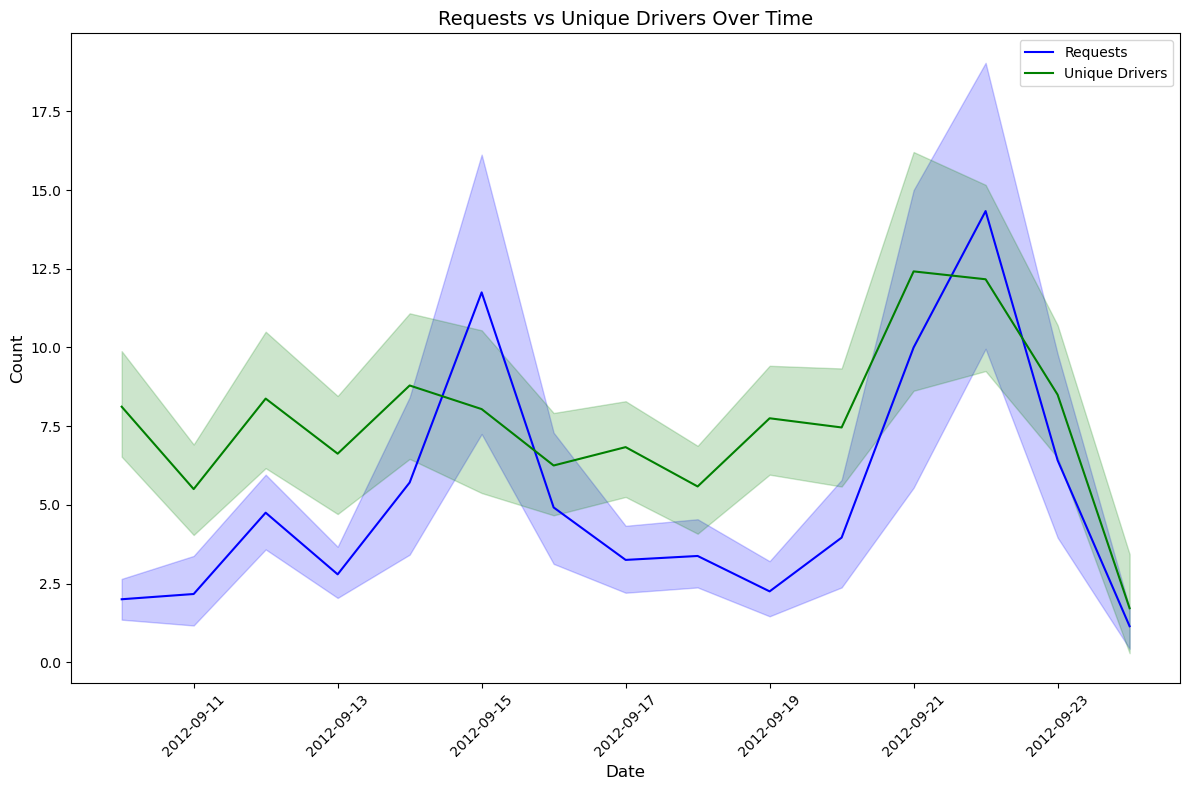

In [13]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%y')

plt.figure(figsize=(12,8))

# Plot Requests and Unique Drivers over time
sns.lineplot(x=data['Date'], y=data['Requests '], label='Requests', color='blue')
sns.lineplot(x=data['Date'], y=data['Unique Drivers'], label='Unique Drivers', color='green')

# Adding title and labels
plt.title('Requests vs Unique Drivers Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**In which 72 hour period is the ratio of Zeroes to Eyeballs the highest?**

In [15]:
# Ensure 'Date' is in datetime format and 'Time (Local)' is treated as hours
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%y')
data['Time (Local)'] = pd.to_numeric(data['Time (Local)'], errors='coerce')

# Create a DateTime column by combining 'Date' and 'Time (Local)'
data['DateTime'] = data['Date'] + pd.to_timedelta(data['Time (Local)'], unit='h')

# Sort the data by 'DateTime' for proper window calculations
data = data.sort_values(by='DateTime')

# Create a rolling 72-hour window using time differences and cumulative sums
data['72h_window'] = data['DateTime'].diff().dt.total_seconds().cumsum() // (72 * 3600)

# Group by the 72-hour windows and sum the Zeroes and Eyeballs for each window
grouped_72h = data.groupby('72h_window').agg({
    'Zeroes ': 'sum',
    'Eyeballs ': 'sum'
}).reset_index()

# Calculate the ratio of Zeroes to Eyeballs for each 72-hour window
grouped_72h['Zeroes_to_Eyeballs_ratio'] = grouped_72h['Zeroes '] / grouped_72h['Eyeballs ']

# Find the 72-hour period with the highest ratio
max_ratio_row = grouped_72h.loc[grouped_72h['Zeroes_to_Eyeballs_ratio'].idxmax()]

print(max_ratio_row)

72h_window                     4.000000
Zeroes                       328.000000
Eyeballs                    1362.000000
Zeroes_to_Eyeballs_ratio       0.240822
Name: 4, dtype: float64


**If you could add 5 drivers to any single hour of every day during the two week period, which hour should you add them to?**

In [17]:
# To determine the best hour to add 5 drivers to each day, we should first find which hour of the day had the highest demand (requests).
# We'll group the data by the hour of the day (ignoring the date) and sum the requests to find the busiest hour.

# Group by the hour of the day and sum the requests
busiest_hour = data.groupby(data['Time (Local)'])['Requests '].sum().idxmax()

# Get the total requests for that hour
total_requests_at_busiest_hour = data.groupby(data['Time (Local)'])['Requests '].sum().max()

busiest_hour, total_requests_at_busiest_hour

(23, 184)

**True or False: There is exactly two weeks of data in this analysis**

In [19]:
# To determine if there is exactly two weeks of data, we can calculate the time difference between the first and last 'DateTime' in the dataset.

# Find the first and last DateTime in the dataset
start_date = data['DateTime'].min()
end_date = data['DateTime'].max()

# Calculate the difference in days
time_difference = (end_date - start_date).days

# Check if the difference is exactly 14 days (two weeks)
is_two_weeks = time_difference == 14

start_date, end_date, time_difference, is_two_weeks

(Timestamp('2012-09-10 07:00:00'), Timestamp('2012-09-24 06:00:00'), 13, False)

**Looking at the data from all two weeks, which time might make the most sense to consider a true "end day" instead of midnight? (i.e when are supply and demand at both their natural minimums)**

In [21]:
# find min supply and demand per day
df_min_supply_per_day = data.groupby(['Date'])['Unique Drivers'].min().reset_index().rename(columns={'Unique Drivers':'min_supply_per_day'})
df_min_demand_per_day = data.groupby(['Date'])['Requests '].min().reset_index().rename(columns={'Requests ':'min_demand_per_day'})

# merge demand and supply based on date
supply_demand = pd.merge(df_min_supply_per_day, df_min_demand_per_day, on="Date")
supply_demand

Date  min_supply_per_day  min_demand_per_day
0  2012-09-10                   3                   0
1  2012-09-11                   0                   0
2  2012-09-12                   0                   0
3  2012-09-13                   0                   0
4  2012-09-14                   0                   1
5  2012-09-15                   0                   0
6  2012-09-16                   0                   0
7  2012-09-17                   0                   0
8  2012-09-18                   0                   0
9  2012-09-19                   0                   0
10 2012-09-20                   0                   0
11 2012-09-21                   0                   0
12 2012-09-22                   0                   0
13 2012-09-23                   0                   0
14 2012-09-24                   0                   0

In [22]:
# merge found min values with initial dataset on Date
dataset_w_min_supply_demand = pd.merge(data, supply_demand, on="Date")
dataset_w_min_supply_demand

Date  Time (Local)  Eyeballs   Zeroes   Completed Trips   Requests   \
0   2012-09-10             7          5        0                 2          2   
1   2012-09-10             8          6        0                 2          2   
2   2012-09-10             9          8        3                 0          0   
3   2012-09-10            10          9        2                 0          1   
4   2012-09-10            11         11        1                 4          4   
..         ...           ...        ...      ...               ...        ...   
331 2012-09-24             2          3        3                 0          2   
332 2012-09-24             3          3        3                 0          1   
333 2012-09-24             4          1        1                 0          0   
334 2012-09-24             5          4        2                 1          1   
335 2012-09-24             6          9        1                 2          2   

     Unique Drivers  Is Weekend  Trips per Driver                    Shift  \
0                 9       False          0.222222  Shift 1 (00:00 - 07:59)   
1                14       False          0.142857  Shift 2 (08:00 - 15:59)   
2                14       False          0.000000  Shift 2 (08:00 - 15:59)   
3                14       False          0.000000  Shift 2 (08:00 - 15:59)   
4                11       False          0.363636  Shift 2 (08:00 - 15:59)   
..              ...         ...               ...                      ...   
331               0       False               NaN  Shift 1 (00:00 - 07:59)   
332               0       False               NaN  Shift 1 (00:00 - 07:59)   
333               0       False               NaN  Shift 1 (00:00 - 07:59)   
334               3       False          0.333333  Shift 1 (00:00 - 07:59)   
335               7       False          0.285714  Shift 1 (00:00 - 07:59)   

     Requests Change  Drivers Change            DateTime  72h_window  \
0                NaN             NaN 2012-09-10 07:00:00         NaN   
1                0.0             5.0 2012-09-10 08:00:00         0.0   
2               -2.0             0.0 2012-09-10 09:00:00         0.0   
3                1.0             0.0 2012-09-10 10:00:00         0.0   
4                3.0            -3.0 2012-09-10 11:00:00         0.0   
..               ...             ...                 ...         ...   
331              2.0             0.0 2012-09-24 02:00:00         4.0   
332             -1.0             0.0 2012-09-24 03:00:00         4.0   
333             -1.0             0.0 2012-09-24 04:00:00         4.0   
334              1.0             3.0 2012-09-24 05:00:00         4.0   
335              1.0             4.0 2012-09-24 06:00:00         4.0   

     min_supply_per_day  min_demand_per_day  
0                     3                   0  
1                     3                   0  
2                     3                   0  
3                     3                   0  
4                     3                   0  
..                  ...                 ...  
331                   0                   0  
332                   0                   0  
333                   0                   0  
334                   0                   0  
335                   0                   0  

[336 rows x 16 columns]

In [23]:
# check the exact matches with natural minimums
min_point = dataset_w_min_supply_demand[(dataset_w_min_supply_demand.min_supply_per_day == dataset_w_min_supply_demand['Unique Drivers']) & 
                           (dataset_w_min_supply_demand.min_demand_per_day == dataset_w_min_supply_demand['Requests '])]['Time (Local)'].mode()
min_point

0    4
Name: Time (Local), dtype: int64

In [24]:
# minimum hour is 4 am
min_point[0]

4

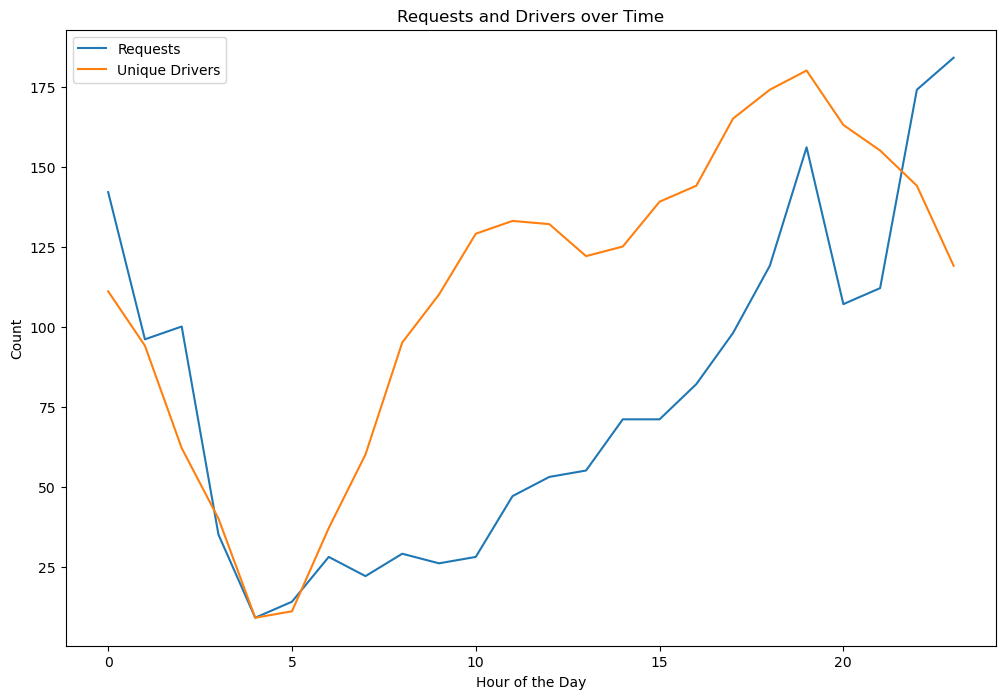

In [25]:
# Group by the hour of the day and sum the numeric columns (ignore datetime columns)
df_agg_time = data.groupby('Time (Local)').sum(numeric_only=True).reset_index()

# Identify the minimum point for requests
min_point = df_agg_time['Requests '].idxmin()

# Plot the data and annotate the minimum point
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot the requests and unique drivers
plt.plot(df_agg_time['Time (Local)'], df_agg_time['Requests '], label='Requests')
plt.plot(df_agg_time['Time (Local)'], df_agg_time['Unique Drivers'], label='Unique Drivers')


# Add title and labels
plt.title('Requests and Drivers over Time')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.legend()

# Display the plot
plt.show()